In [41]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [42]:
torch.cuda.is_available()

True

In [43]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [44]:
def preprocess(img):
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [45]:
class CartPole(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CartPole, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.fc(x)
    
def policy_gradient(learning_rate = .01, discount = .95, num_episodes = 1000, env_name = "CartPole-v1"):
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    
    policy = CartPole(input_dim, output_dim)
    optimizer = torch.optim.Adam(policy.parameters(), lr = learning_rate)
    
    r_episode  = []
    r_moving_avg = []
    
    for episode in tqdm(range(num_episodes), desc = "Training"):
        state,_ = env.reset()
        rewards = []
        log_action = []
        
        while True:
            state_tensor = torch.FloatTensor(state)
            action_prob = torch.softmax(policy(state_tensor), dim = 0)
            action_dist = torch.distributions.Categorical(action_prob)
            action = action_dist.sample()

            next_state, reward, done, _, _ = env.step(action.item())

            log_action.append(action_dist.log_prob(action))
            rewards.append(reward)
            state = next_state
            
            if done:
                break
            
        r_episode.append(sum(rewards))
        
        if len(r_episode) >= 100:
            r_moving_avg.append(np.mean(r_episode[-100:]))
            
        r_discounted = []
        discounted_R = 0
        for r in reversed(rewards):
            discounted_R = r + discount * discounted_R
            r_discounted.insert(0, discounted_R)
        r_discounted = torch.FloatTensor(r_discounted)
        
        r_discounted = (r_discounted - r_discounted.mean())/(r_discounted + 1e-6)
        
        loss = []
        for act, rew in zip(log_action, r_discounted):
            loss.append(-act*rew)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1)%100 == 0:
            tqdm.write(f"episode: {episode  + 1}, reward: {np.mean(r_episode)}")
        
    return policy, r_episode, r_moving_avg
        

In [46]:
trained_policy, episode_rewards, moving_average_rewards = policy_gradient()

Training:  12%|█▏        | 122/1000 [00:01<00:08, 108.59it/s]

episode: 100, reward: 14.93


Training:  20%|██        | 203/1000 [00:03<00:26, 30.14it/s] 

episode: 200, reward: 19.235


Training:  26%|██▌       | 261/1000 [00:26<01:15,  9.78it/s]


KeyboardInterrupt: 

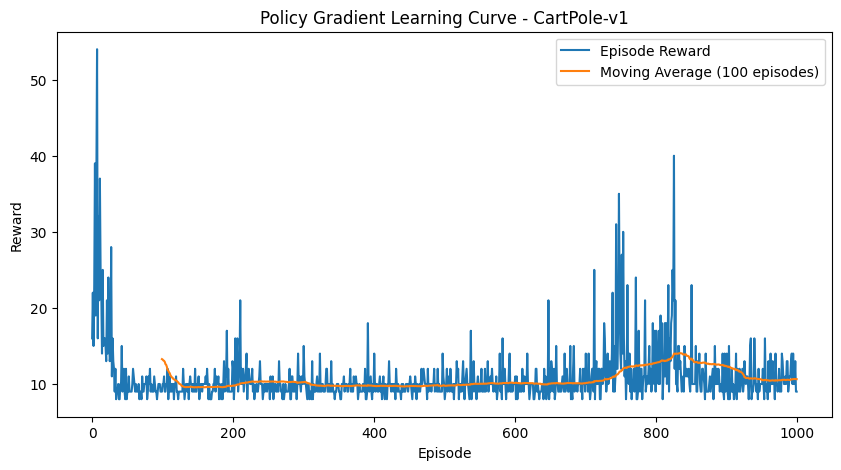

In [40]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_average_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - CartPole-v1')
plt.legend()
plt.show()